In [1]:
import os
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import IPython
from tqdm import tqdm
from datetime import datetime
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, accuracy_score, roc_curve, precision_recall_fscore_support

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import MultiStepLR


In [3]:
path = '/Users/ppangppang/Documents/dev/TIL/dacon/data/'

# train = pd.read_csv(path+'processed/processed_train.csv')
# test = pd.read_csv(path+'processed/processed_test.csv')

train = pd.read_csv(path+'processed/processed_train_impyute.csv')
test = pd.read_csv(path+'processed/processed_test_impyute.csv')

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(2022)

In [4]:
t_params = {
        'encode_layer' : [27,14,7,3],
        'decode_layer' : [3,7,14,27],            
        'zc_dim': 1,
        'n_gmm': 21, 
        'dropout': 0.5, 
        'lambda1': 0.001,
        'lambda2': 0.005,
        'epochs': 35, 
        'lr': 1e-3, 
        'batch_size': 64, 
        'train_iter': 100,
        'val_iter': 50,
        'es_patience': 2,
        'ratio': 0.8,
        'save_path': './',
        'result_path': './',
        'tunning_steps': 50
    }

In [5]:
test_stage_features = test.columns.to_list()

### DAGMM 적용을 위한 데이터 분할
- train 11000개 (정상) 80%
- val 3095개 (이상) 20%

In [6]:
nor_trn = train[train['Y_LABEL']==0]
abn_trn = train[train['Y_LABEL']==1]
trn = nor_trn.sample(frac=1, random_state=2022).reset_index(drop=True).iloc[:10000,:]
val = pd.concat([nor_trn.sample(frac=1, random_state=2022).reset_index(drop=True).iloc[10000:,:], abn_trn])

In [7]:
class BuildDataset(Dataset):
    def __init__(self, data, label=False, distillation=False):
        super(BuildDataset, self).__init__()
        self.distillation = distillation
            
        if label==False:
            self.data = data
            self.label = np.zeros(len(self.data), dtype=np.int8)
        else:
            self.data = data.iloc[:,:-1]
            self.label = data.iloc[:,-1].values
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.distillation:
            # 지식 증류 학습 시
            teacher_X = torch.FloatTensor(self.data.iloc[idx])
            student_X = torch.FloatTensor(self.data[test_stage_features].iloc[idx])
            y = self.label[idx]
            return teacher_X, student_X, y
        
        else:
            if self.label is None:
                test_X = torch.FloatTensor(self.data.iloc[idx])
                return test_X
            
            else:
                teacher_X = torch.FloatTensor(self.data.iloc[idx])
                y = self.label[idx]
                return teacher_X, y

## 모델

In [8]:
class EarlyStop():
    """
    학습 모델 저장 및 오버핏 방지를 위한 EarlyStop기능
    :return : save best model file
    """
    def __init__(self, params=None, verbose=True):

        self.save_path = params['save_path']
        self.patience = params['es_patience']
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.save_info = datetime.now().strftime(format='%y%m%d_%H%M')
        # self.data_name = self.args.train_data.split('/')[-1].split('.')[-2]

    def __call__(self, val_loss, model, optimizer, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, epoch)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, epoch)
            self.counter = 0

        return self.early_stop


    def save_checkpoint(self, val_loss, model, optimizer, epoch):
        if self.verbose:
            print(f'Validation loss decreased {self.val_loss_min:.6f} --> {val_loss:.6f}.  \n--------------------Saving model--------------------\n')

        torch.save(model.state_dict(), self.save_path + f'/{self.save_info}_epoch{epoch+1}.pt')
        self.val_loss_min = val_loss


In [9]:
class BuildModel(nn.Module):
  
    def __init__(self, params=None):
        super(BuildModel, self).__init__()
        
        params['encode_layer'].insert(0,params['input_dim'])
        params['decode_layer'].insert(len(params['decode_layer']), params['input_dim'])
        
        layers = []
        for i in range(len(params['encode_layer'])-1):
            layers += [nn.Linear(params['encode_layer'][i], params['encode_layer'][i+1])]
            layers += [nn.ReLU()]
        layers += [nn.Linear(params['encode_layer'][-1], params['zc_dim'])]

        self.encoder = nn.Sequential(*layers)

        layers = []
        layers += [nn.Linear(params['zc_dim'], params['decode_layer'][0])]
        
        for i in range(len(params['decode_layer'])-1):
            layers += [nn.ReLU()]
            layers += [nn.Linear(params['decode_layer'][i], params['decode_layer'][i+1])]
            
        self.decoder = nn.Sequential(*layers)

        layers = []
        layers += [nn.Linear(params['zc_dim']+2, params['encode_layer'][-1])]
        layers += [nn.ReLU()]        
        layers += [nn.Dropout(p=params['dropout'])]        
        layers += [nn.Linear(params['encode_layer'][-1], params['n_gmm'])]
        layers += [nn.Softmax(dim=1)]

        self.estimation = nn.Sequential(*layers)

        self.lambda1 = params['lambda1']
        self.lambda2 = params['lambda2']
        
        params['encode_layer'].pop(0)
        params['decode_layer'].pop(-1)

    def forward(self, x):
        encoder = self.encoder(x)
        decoder = self.decoder(encoder)
        
        rec_cosine = F.cosine_similarity(x, decoder, dim=1)
        rec_euclidean = F.pairwise_distance(x, decoder,p=2)
    
        z = torch.cat([encoder, rec_euclidean.unsqueeze(-1), rec_cosine.unsqueeze(-1)], dim=1)

        gamma = self.estimation(z)
        
        return encoder, decoder, z, gamma
    
    
    @staticmethod
    def reconstruction_error(x, x_hat):     
        e = torch.tensor(0.0)
        for i in range(x.shape[0]):
            e += torch.dist(x[i], x_hat[i])
        return e / x.shape[0]
    
    
    @staticmethod
    def get_gmm_param(gamma, z):     
        N = gamma.shape[0]
        ceta = torch.sum(gamma, dim=0) / N  #shape: [n_gmm]
        
        mean = torch.sum(gamma.unsqueeze(-1) * z.unsqueeze(1), dim=0)
        mean = mean / torch.sum(gamma, dim=0).unsqueeze(-1)  #shape: [n_gmm, z_dim]
            

        z_mean = (z.unsqueeze(1)- mean.unsqueeze(0))
        cov = torch.sum(gamma.unsqueeze(-1).unsqueeze(-1) * z_mean.unsqueeze(-1) * z_mean.unsqueeze(-2), dim = 0) / torch.sum(gamma, dim=0).unsqueeze(-1).unsqueeze(-1)
            
        return ceta, mean, cov
    

    @staticmethod
    def sample_energy(ceta, mean, cov, zi, n_gmm, bs):
        e = torch.tensor(0.0)
        cov_eps = torch.eye(mean.shape[1]) * (1e-3) # original constant: 1e-12

        for k in range(n_gmm):
            miu_k = mean[k].unsqueeze(1)
            d_k = zi - miu_k

            inv_cov = torch.inverse(cov[k] + cov_eps)
            
            e_k = torch.exp(-0.5 * torch.chain_matmul(torch.t(d_k), inv_cov, d_k))
            e_k = e_k / torch.sqrt(torch.abs(torch.det(2 * math.pi * cov[k])))
            e_k = e_k * ceta[k]
            e += e_k.squeeze()
            
        return -torch.log(e)
    

    def loss_func(self, x, decoder, gamma, z):
        bs,n_gmm = gamma.shape[0], gamma.shape[1]        
        #1
        recon_error = self.reconstruction_error(x, decoder)
        
        #2
        ceta, mean, cov = self.get_gmm_param(gamma, z)
        
        e = torch.tensor(0.0)
        for i in range(z.shape[0]):
            zi = z[i].unsqueeze(1)
            ei = self.sample_energy(ceta, mean, cov, zi,n_gmm,bs)
            e += ei

        #3
        p = torch.tensor(0.0)
        for k in range(n_gmm):
            cov_k = cov[k]
            p_k = torch.sum(1 / torch.diagonal(cov_k, 0))
            p += p_k
            
        loss = recon_error + (self.lambda1 / z.shape[0]) * e   + self.lambda2 * p
        
        return loss, recon_error, e/z.shape[0], p

In [10]:
def train_loss_plot(losses):
    """
    train_loss plot 시각화
    """        
    plt.clf()
    _, ax = plt.subplots(figsize=(10,5), dpi=80)
    ax.plot(losses, 'blue', label='train', linewidth=1)
    ax.set_title('Loss change in training')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Iteration')
    ax.legend(loc='upper right')

    plt.show()


def validation_loss_plot(losses):
    """
    validation_loss plot 시각화
    """          
    plt.clf()
    _, ax = plt.subplots(figsize=(10,5), dpi=80)
    ax.plot(losses, 'blue', label='val', linewidth=1)
    ax.set_title('Loss change in validation')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Iteration')
    ax.legend(loc='upper right')

    plt.show()

In [11]:
def train_teacher(model, train_dataloader, valid_dataloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    optim = torch.optim.Adam(model.parameters(), t_params['lr'], amsgrad=True)
    scheduler = MultiStepLR(optim, [5, 8], 0.1)

    total_loss, total_recon_error, total_e, total_p = 0, 0, 0, 0
    loss_plot, val_loss_plot = [], []

    for epoch in range(t_params['epochs']):
        for step, (input_data, _) in enumerate(tqdm(train_dataloader, desc=f'epcoch{epoch+1}')):
            input_data = input_data.to(device)
            model.train()
            optim.zero_grad()
            input_data = input_data.squeeze(1)
            encoder, decoder, z, gamma = model(input_data)
            input_data, decoder, z, gamma = input_data.cpu(), decoder.cpu(), z.cpu(), gamma.cpu()
            loss, recon_error, e, p = model.loss_func(input_data, decoder, gamma, z)
    
            total_loss += loss.item()
            total_recon_error += recon_error.item()
            total_e += e.item()
            total_p += p.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optim.step()
            
            if (step+1) % t_params['train_iter'] == 0:

                log = '\nlr {}, loss {:.2f}, recon_error {:.2f}, energy {:.2f}, p_diag {:.2f}'.format(optim.param_groups[0]['lr'], 
                                                                                                total_loss/t_params['train_iter'], 
                                                                                                total_recon_error/t_params['train_iter'], 
                                                                                                total_e/t_params['train_iter'], 
                                                                                                total_p/t_params['train_iter'])

                IPython.display.clear_output()
                print(log)
                loss_plot.append(total_loss/t_params['train_iter'])
                train_loss_plot(loss_plot)
                total_loss, total_recon_error, total_e, total_p = 0, 0, 0, 0

        with torch.no_grad():
            print("----------------------Validation----------------------\n")
            val_total_loss, val_total_recon_error, val_total_e, val_total_p = 0, 0, 0, 0

            model.eval()
            for step, (input_data,_) in enumerate(tqdm(valid_dataloader, desc="Val")):
                input_data = input_data.to(device)
                input_data = input_data.squeeze(1)
                encoder,decoder,z,gamma = model(input_data)
                input_data,decoder,z,gamma = input_data.cpu(),decoder.cpu(),z.cpu(),gamma.cpu()
                loss, recon_error, e, p = model.loss_func(input_data, decoder, gamma, z)

                val_total_loss += loss.item()
                val_total_recon_error += recon_error.item()
                val_total_e += e.item()
                val_total_p += p.item()
                
                if (step+1) % t_params['val_iter'] == 0:
                    log = '\n val_loss {:.2f}, recon_error {:.2f}, energy {:.2f}, p_diag {:.2f}'.format(
                                                                        val_total_loss/t_params['val_iter'], 
                                                                        val_total_recon_error/t_params['val_iter'], 
                                                                        val_total_e/t_params['val_iter'], 
                                                                        val_total_p/t_params['val_iter']) 

                    IPython.display.clear_output()
                    print(log)
                    val_loss_plot.append(val_total_loss/t_params['val_iter'])
                    validation_loss_plot(val_loss_plot)
                    val_total_loss, val_total_recon_error, val_total_e, val_total_p = 0, 0, 0, 0

        scheduler.step() 
        train_loss_plot(loss_plot)
    print('\n-------------Train Finished-------------')
    
    return model

In [12]:
t_train_dataset = BuildDataset(trn.iloc[:int(len(trn)*0.9),:-1],distillation=False)
t_train_loader = DataLoader(t_train_dataset, batch_size = t_params['batch_size'], shuffle=True)

t_val_dataset = BuildDataset(trn.iloc[int(len(trn)*0.9):,:-1], distillation=False)
t_val_loader = DataLoader(t_val_dataset, batch_size = t_params['batch_size'], shuffle=False)

In [13]:
t_params['input_dim'] = trn.iloc[:,:-1].shape[1]
t_model = BuildModel(params=t_params)

In [14]:
# t_model


lr 1e-05, loss 2.09, recon_error 1.60, energy 2.50, p_diag 98.18


<Figure size 640x480 with 0 Axes>

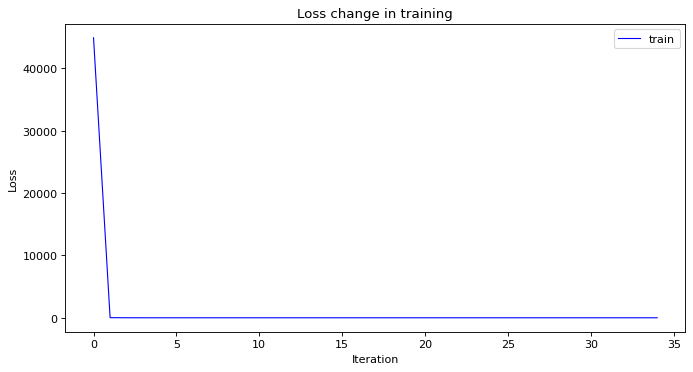

epcoch35: 100%|██████████| 141/141 [01:26<00:00,  1.63it/s]


----------------------Validation----------------------



Val: 100%|██████████| 16/16 [00:03<00:00,  4.83it/s]


<Figure size 640x480 with 0 Axes>

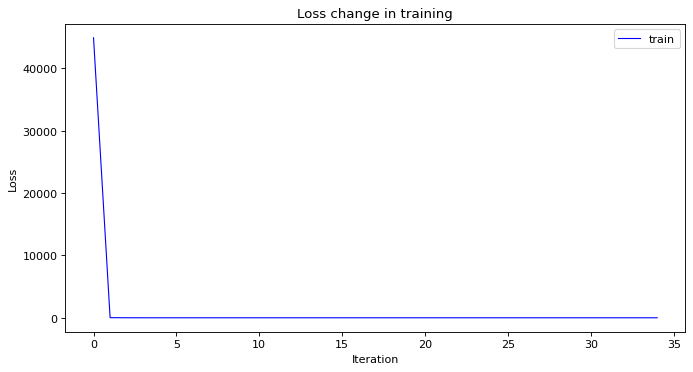


-------------Train Finished-------------


In [15]:
best_t_model = train_teacher(t_model, t_train_loader, t_val_loader)

In [16]:
s_params = {
        'encode_layer' : [11,6,3],
        'decode_layer' : [3,6,11],            
        'zc_dim': 1,
        'n_gmm': 21, 
        'dropout': 0.5, 
        'lambda1': 0.001,
        'lambda2': 0.005,
        'epochs': 30, 
        'lr': 1e-3, 
        'batch_size': 64, 
        'train_iter': 100,
        'val_iter': 50,
        'es_patience': 2,
        'ratio': 0.8,
        'save_path': './',
        'result_path': './',
        'tunning_steps': 50
    }

## student model

In [17]:
def train_student(t_model, s_model, train_dataloader, valid_dataloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    t_model = t_model.to(device)
    s_model = s_model.to(device)

    optim = torch.optim.Adam(s_model.parameters(), s_params['lr'], amsgrad=True)
    scheduler = MultiStepLR(optim, [5, 8], 0.1)    

    total_loss, total_recon_error, total_e, total_p = 0, 0, 0, 0
    loss_plot, val_loss_plot = [], []

    for epoch in range(s_params['epochs']):
        for step,(t_input_data, s_input_data, _) in enumerate(tqdm(train_dataloader, desc=f'epcoch{epoch+1}')):
            
            s_model.train()
            s_input_data = s_input_data.to(device)
            optim.zero_grad()
            s_input_data = s_input_data.squeeze(1)
            encoder, decoder, z, gamma = s_model(s_input_data)
            s_input_data, decoder, z, gamma = s_input_data.cpu(), decoder.cpu(), z.cpu(), gamma.cpu()
            s_loss, recon_error, e, p = s_model.loss_func(s_input_data, decoder, gamma, z)
            
            t_model.eval()
            with torch.no_grad():
                t_input_data = t_input_data.to(device)
                t_input_data = t_input_data.squeeze(1)
                encoder,decoder,z,gamma = t_model(t_input_data)
                t_input_data,decoder,z,gamma = t_input_data.cpu(),decoder.cpu(),z.cpu(),gamma.cpu()
                t_loss, _,_,_ = t_model.loss_func(t_input_data, decoder, gamma, z)            
                
            loss = 0.9*s_loss + 0.1*t_loss
            
            total_loss += loss.item()
            total_recon_error += recon_error.item()
            total_e += e.item()
            total_p += p.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(s_model.parameters(), 5)
            optim.step()
            
            if (step+1) % s_params['train_iter'] == 0:

                log = '\nlr {}, loss {:.2f}, recon_error {:.2f}, energy {:.2f}, p_diag {:.2f}'.format(optim.param_groups[0]['lr'], 
                                                                                                total_loss/s_params['train_iter'], 
                                                                                                total_recon_error/s_params['train_iter'], 
                                                                                                total_e/s_params['train_iter'], 
                                                                                                total_p/s_params['train_iter'])                
                IPython.display.clear_output()
                print(log)
                loss_plot.append(total_loss/s_params['train_iter'])
                train_loss_plot(loss_plot)
                total_loss, total_recon_error, total_e, total_p = 0, 0, 0, 0

        with torch.no_grad():
            print("----------------------Validation----------------------\n")
            val_total_loss, val_total_recon_error, val_total_e, val_total_p = 0, 0, 0, 0
            
            for step,(t_input_data, s_input_data, _) in enumerate(tqdm(valid_dataloader, desc="Val")):
                
                s_model.eval()
                s_input_data = s_input_data.to(device)
                s_input_data = s_input_data.squeeze(1)
                encoder, decoder, z, gamma = s_model(s_input_data)
                s_input_data, decoder, z, gamma = s_input_data.cpu(), decoder.cpu(), z.cpu(), gamma.cpu()
                s_loss, recon_error, e, p = s_model.loss_func(s_input_data, decoder, gamma, z)

                t_model.eval()
                t_input_data = t_input_data.to(device)
                t_input_data = t_input_data.squeeze(1)
                encoder,decoder,z,gamma = t_model(t_input_data)
                t_input_data,decoder,z,gamma = t_input_data.cpu(),decoder.cpu(),z.cpu(),gamma.cpu()
                t_loss, _,_,_ = t_model.loss_func(t_input_data, decoder, gamma, z)            
                
                val_total_loss = s_loss + t_loss
                
                if (step+1) % s_params['val_iter'] == 0:
                    
                    log = '\n val_loss {:.2f}, recon_error {:.2f}, energy {:.2f}, p_diag {:.2f}'.format(
                                                                            val_total_loss/s_params['val_iter'], 
                                                                            val_total_recon_error/s_params['val_iter'], 
                                                                            val_total_e/s_params['val_iter'], 
                                                                            val_total_p/s_params['val_iter'])
                    IPython.display.clear_output()
                    print(log)
                    loss_plot.append(val_total_loss/s_params['val_iter'])
                    validation_loss_plot(loss_plot)
                    val_total_loss, val_total_recon_error, val_total_e, val_total_p = 0, 0, 0, 0

        scheduler.step() 
        train_loss_plot(loss_plot)
    print('\n-------------Train Finished-------------')
    return s_model

In [18]:
s_train_dataset = BuildDataset(trn.iloc[:int(len(trn)*0.9),:-1], distillation=True)
s_train_loader = DataLoader(s_train_dataset, batch_size = s_params['batch_size'], shuffle=True)

s_val_dataset = BuildDataset(trn.iloc[int(len(trn)*0.9):,:-1], distillation=True)
s_val_loader = DataLoader(s_val_dataset, batch_size = s_params['batch_size'], shuffle=False)

In [19]:
s_params['input_dim'] = len(test.columns)
s_model = BuildModel(params=s_params)

In [20]:
# s_model


lr 1e-05, loss 3.52, recon_error 1.50, energy 2.33, p_diag 176.24


<Figure size 640x480 with 0 Axes>

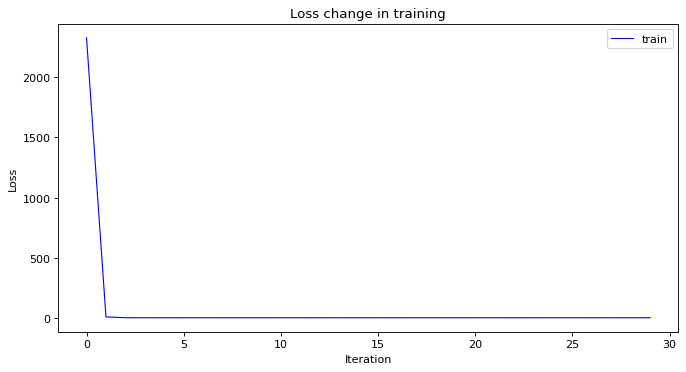

epcoch30: 100%|██████████| 141/141 [02:01<00:00,  1.16it/s]


----------------------Validation----------------------



Val: 100%|██████████| 16/16 [00:07<00:00,  2.27it/s]


<Figure size 640x480 with 0 Axes>

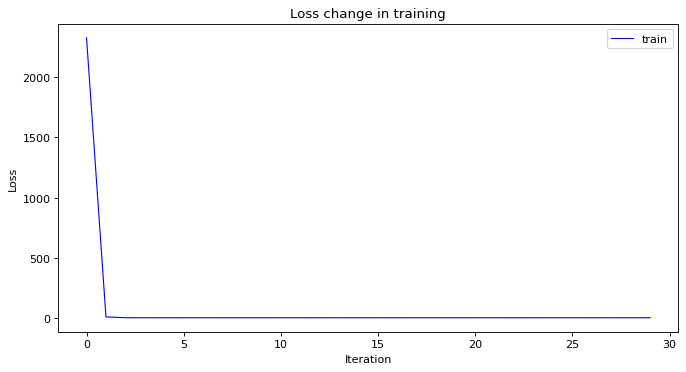


-------------Train Finished-------------


In [21]:
best_s_model = train_student(t_model, s_model, s_train_loader, s_val_loader)

### inference에 필요

In [22]:
def compute_threshold(model, train_loader,len_data):
    energies = np.zeros(shape=(len_data))
    step = 0
    energy_interval = 50

    with torch.no_grad():
        for _, x, y in train_loader:

            enc,dec,z,gamma = model(x)
            m_prob, m_mean, m_cov = model.get_gmm_param(gamma, z)
            
            for i in range(z.shape[0]):
                zi = z[i].unsqueeze(1)
                sample_energy = model.sample_energy(m_prob, m_mean, m_cov, zi,gamma.shape[1], gamma.shape[0])

                energies[step] = sample_energy.detach().item()
                step += 1

            if step % energy_interval == 0:
                print('Iteration: %d    sample energy: %.4f' % (step, sample_energy))
    
    threshold = np.percentile(energies, 80)
    print('threshold: %.4f' %(threshold))
    
    return threshold

In [23]:
def predict(s_model, train_dataloader, len_train, test_dataloader, len_test, threshold=True):
    device = torch.device('cpu')
    model = s_model.to(device)
    model.eval()
    
    if threshold == False:
        threshold = compute_threshold(model,train_dataloader,len_train)
    else:
        threshold = -1.1974


    pred = np.zeros(len_test)
    step = 0

    with torch.no_grad():
        for _, s_input_data, y in tqdm(test_dataloader, desc='caluate energy'):
            s_input_data = s_input_data.squeeze(1)
            encoder , decoder, z, gamma = model(s_input_data)            
            m_prob, m_mean, m_cov = model.get_gmm_param(gamma, z)
            
            for i in range(z.shape[0]):
                zi = z[i].unsqueeze(1)
                sample_energy = model.sample_energy(m_prob, m_mean, m_cov, zi, gamma.shape[1], gamma.shape[0])
                se = sample_energy.detach().item()
                
                pred[step] = int(se > threshold)
                step += 1
                
        return pred

## train의 일부로 평가(자체평가) -> 이거 s_train_loader 전체데이터로 바꾸기

In [24]:
full_train_dataset = BuildDataset(trn.iloc[:,:-1], distillation=True)
s_full_train_loader = DataLoader(full_train_dataset, batch_size = s_params['batch_size'], shuffle=False)
len_train = len(full_train_dataset)

test_dataset = BuildDataset(val, label=True, distillation=True)
s_test_dataset = DataLoader(test_dataset, batch_size = s_params['batch_size'], shuffle=False)
len_test = len(test_dataset)

In [25]:
pred = predict(s_model, s_full_train_loader, len_train, s_test_dataset, len_test, threshold=False)
len(pred)

Iteration: 1600    sample energy: 1.3568
Iteration: 3200    sample energy: 1.0936
Iteration: 4800    sample energy: 0.7393
Iteration: 6400    sample energy: 1.8855
Iteration: 8000    sample energy: 1.9370
Iteration: 9600    sample energy: 0.9525
Iteration: 10000    sample energy: -0.4953
threshold: 2.0012


caluate energy: 100%|██████████| 64/64 [00:15<00:00,  4.01it/s]


4095

In [26]:
temp = val.copy()
temp['pred'] = pred
precision, recall, fscore, support = precision_recall_fscore_support(temp['Y_LABEL'], temp['pred'], average='binary', labels=[1,0])
print('Precision: %.4f  Recall: %.4f  F-score: %.4f' % (precision, recall, fscore))
confusion_matrix(temp['Y_LABEL'], temp['pred'], labels=[1,0])

Precision: 0.3389  Recall: 0.2186  F-score: 0.2658


array([[ 263,  940],
       [ 513, 2379]], dtype=int64)

## test 데이터를 불러와서 로더로 바꾸고 에너지 구하고 pred 구해서 제출

In [27]:
real_test_dataset = BuildDataset(test, distillation=True)
s_real_test_dataset = DataLoader(real_test_dataset, batch_size = s_params['batch_size'], shuffle=False)
len_test = len(real_test_dataset)

In [28]:
pred = predict(s_model, s_full_train_loader, len_train, s_test_dataset, len_test, threshold=False)
len(pred)

Iteration: 1600    sample energy: 1.3568
Iteration: 3200    sample energy: 1.0936
Iteration: 4800    sample energy: 0.7393
Iteration: 6400    sample energy: 1.8855
Iteration: 8000    sample energy: 1.9370
Iteration: 9600    sample energy: 0.9525
Iteration: 10000    sample energy: -0.4953
threshold: 2.0012


caluate energy: 100%|██████████| 64/64 [00:15<00:00,  4.03it/s]


6041

In [29]:
submit = pd.read_csv(path + '/raw/sample_submission.csv')
submit['Y_LABEL'] = pred
submit.head()

,ID,Y_LABEL
0,TEST_0000,0.0
1,TEST_0001,0.0
2,TEST_0002,0.0
3,TEST_0003,1.0
4,TEST_0004,1.0


In [30]:
submit.to_csv(path + './221118_2.csv', index=False)